# AIPI 590 - XAI | Assignment #03

### Osama Ahmed


![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/osama-shawir/Interpretable-ML-Models/blob/main/interpretable_ml.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/osama-shawir/Interpretable-ML-Models/blob/main/interpretable_ml.ipynb)  

This project involves analyzing a dataset from a telecommunications company to understand the factors contributing to customer churn and developing interpretable models to predict which customers are at risk of churning. The notebook includes performing exploratory data analysis (EDA), building and interpreting linear regression, logistic regression, and generalized additive models (GAM), and comparing the performance and interpretability of these models. The goal is to provide actionable insights and recommendations for the telecommunications company to address customer churn effectively.

##### We start by loading the necessary libraries and the dataset.

In [1]:
# Clone the GitHub repository
!git clone https://github.com/osama-shawir/Interpretable-ML-Models
%cd Interpretable-ML-Models

# Uncomment the next line to install pygam
# !pip install pygam

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s, f

# Set display option to show all columns
pd.set_option("display.max_columns", None)

# Set plot style
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display the first few rows of the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### First few rows of the dataset look fine. Lets take a look at the datatypes and the missing values in the dataset.

In [2]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### The dataset has 7043 rows and 21 columns. The columns are of type object, int64, and float64. There are no missing values in the dataset. The target variable is 'Churn' which is a binary variable indicating whether the customer churned or not. The dataset contains both numerical and categorical features. We will perform exploratory data analysis (EDA) to understand the distribution of the features and their relationship with the target variable.

In [3]:
# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# remove columns that are not valid categorical features
for col in ["customerID", "Churn", "TotalCharges"]:
    if col in categorical_features:
        categorical_features.remove(col)

# Convert TotalCharges to numeric and add to numeric_features
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
numeric_features.append("TotalCharges")

# Check for missing values after converting TotalCharges to numeric
df["TotalCharges"].isnull().sum()

11

##### Changing Total Charges to numeric introduces some missing values. We will drop these rows as they are very few.

In [4]:
df.dropna(inplace=True)

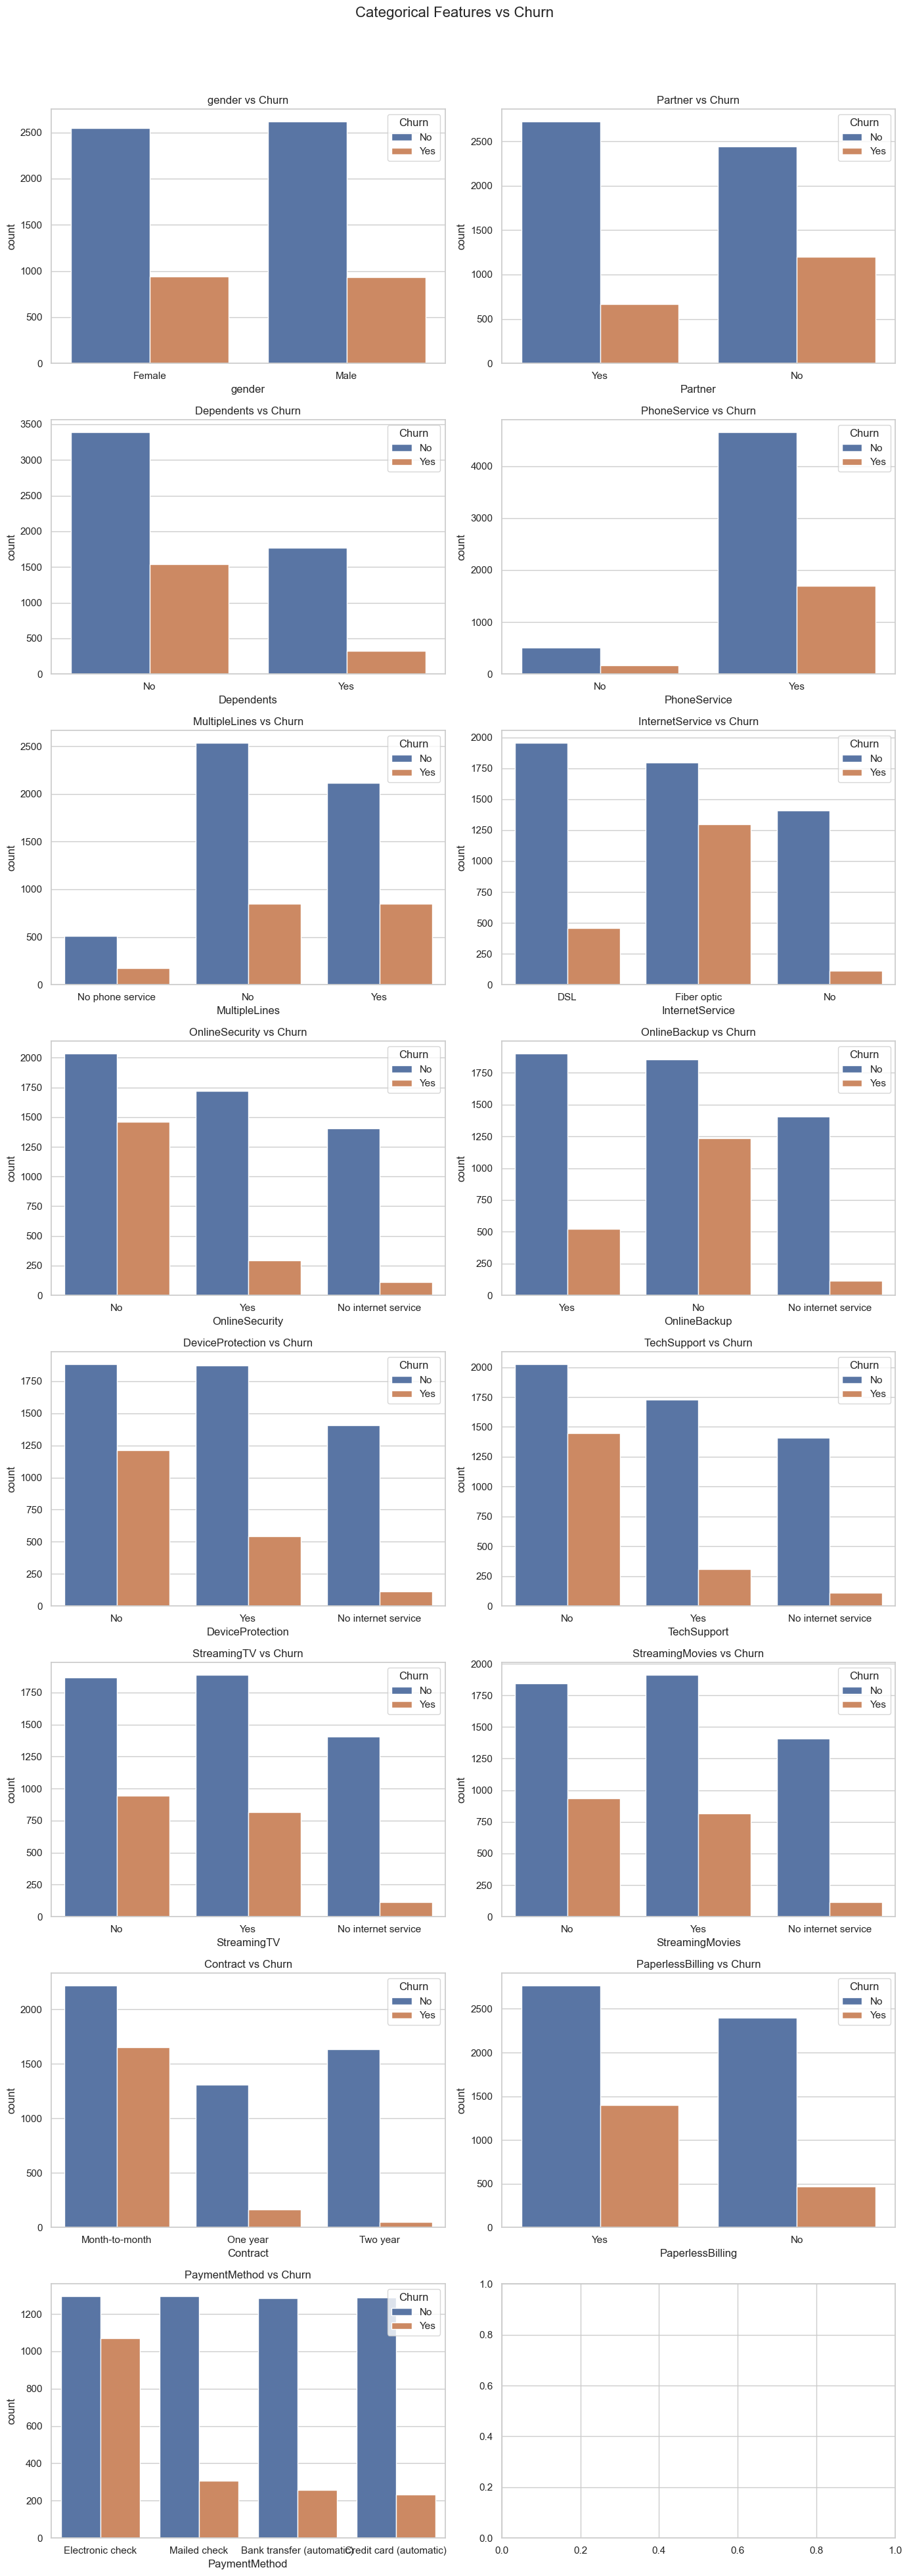

In [5]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 40))
fig.suptitle("Categorical Features vs Churn", fontsize=16)

# Plot each feature against Churn
for feature, ax in zip(categorical_features, axes.flatten()):
    sns.countplot(x=feature, hue="Churn", data=df, ax=ax)
    ax.set_title(f"{feature} vs Churn")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### We can see that some features seem to have even distribution between churn and non-churn customers, while others show a significant difference. For example, churn customers seem to be evenly distributed, while people with dependents seem much less likely to churn. We will further investigate these relationships when we start building the models.

### Linear Regression

We will start by building a linear regression model to predict customer churn.

c:\Users\osama\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\osama\miniconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                            OLS Regression Results                            
Dep. Variable:              Churn_Yes   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     120.9
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:47:14   Log-Likelihood:                -3057.9
No. Observations:                7032   AIC:                             6164.
Df Residuals:                    7008   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

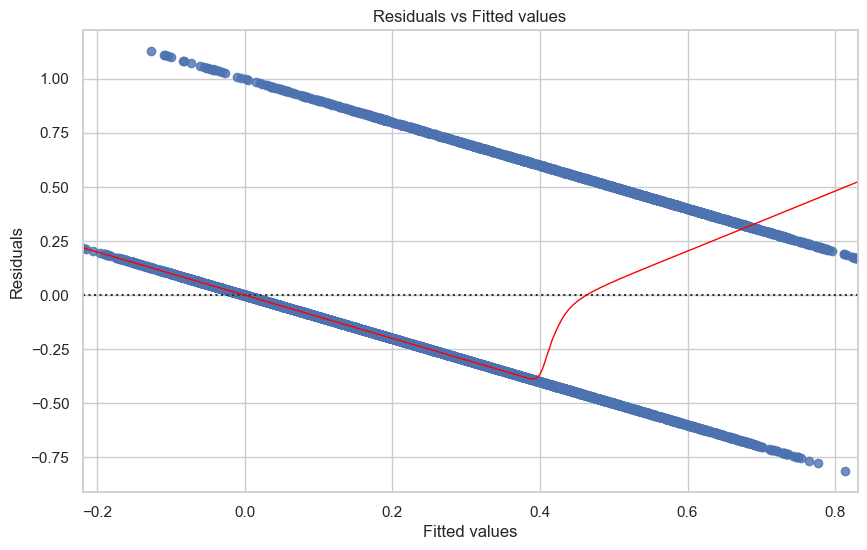

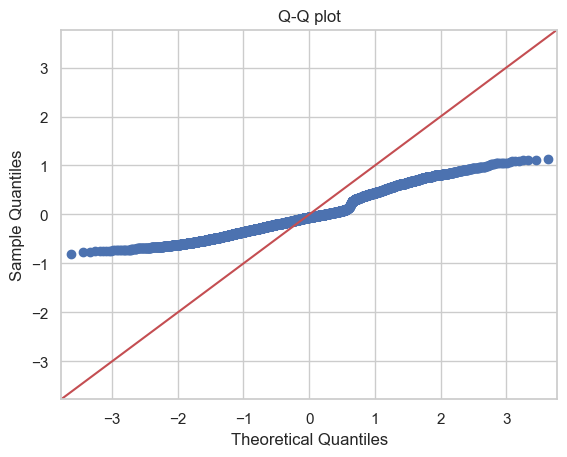

In [6]:
# Convert categorical variables to dummy variables
categorical_features.append("Churn")
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True).astype(int)

# Combine dummy variables with numerical columns
df_combined = pd.concat([df[numeric_features], df_dummies], axis=1)

# Define the target variable and features
X = df_combined.drop("Churn_Yes", axis=1)  # Assuming 'Churn' is the target variable
y = df_combined["Churn_Yes"]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

# Check for linearity assumptions
# Plot the residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.residplot(
    x=model.fittedvalues, y=model.resid, lowess=True, line_kws={"color": "red", "lw": 1}
)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted values")
plt.show()

# Plot the Q-Q plot for normality of residuals
sm.qqplot(model.resid, line="45")
plt.title("Q-Q plot")
plt.show()

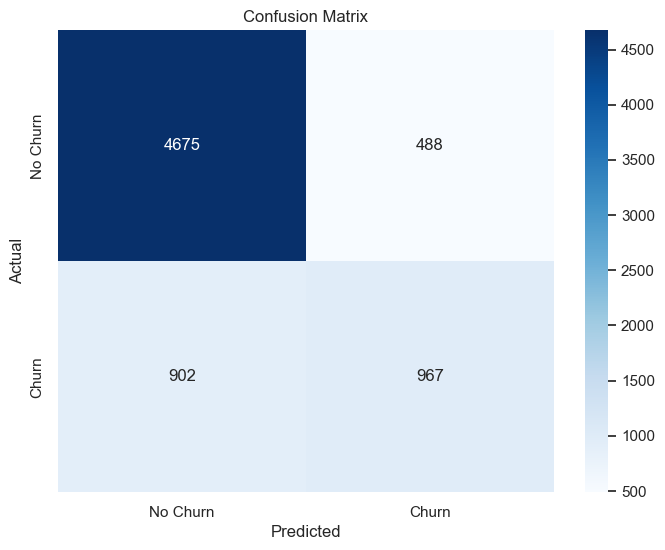

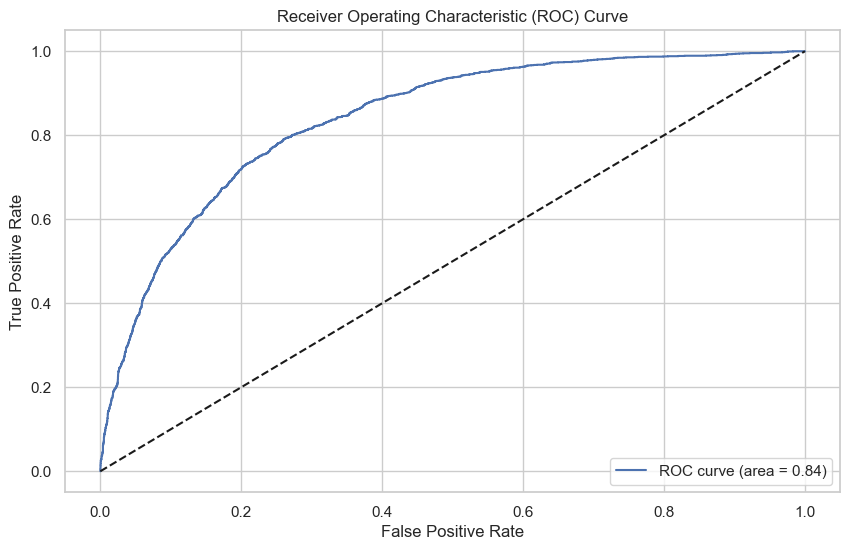

In [7]:
# Make predictions
y_pred_continuous = model.predict(X)

# Convert continuous predictions to binary outcomes
y_pred_binary = y_pred_continuous > 0.5

# Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y, y_pred_continuous)
roc_auc = roc_auc_score(y, y_pred_continuous)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

### **Model Summary:**
- **R-squared**: 0.284 — This indicates that about 28.4% of the variation in the dependent variable (Churn) is explained by the independent variables in the model. This is a relatively low R-squared, implying there is a lot of unexplained variation, suggesting other factors might influence churn that are not included in this model or that this model is not a good choice for the data.

- Other metrics like **Adjusted R-squared**, **F-statistic**, and **Prob (F-statistic)** are also provided, which are useful for evaluating the overall significance of the model.

---

### **Coefficients:**

- **Intercept (const)**: 0.2737 — When all other variables are 0, the predicted value for churn is 0.2737. The p-value (0.008) indicates that this is statistically significant.

#### Statistically Significant Variables (p-value < 0.05):
1. **SeniorCitizen** (coef: 0.0445) — Being a senior citizen increases the likelihood of churn by 0.0445, and this effect is statistically significant (p = 0.001).
   
2. **tenure** (coef: -0.0020) — For each additional unit of tenure, the likelihood of churn decreases slightly by 0.0020. This variable is highly significant (p = 0.000).
   
3. **TotalCharges** (coef: -4.438e-05) — Higher total charges are associated with lower churn, though the effect size is very small. This is statistically significant (p = 0.000).
   
4. **MultipleLines_No phone service** (coef: 0.1396) — Customers with no phone service are 13.96% more likely to churn, and this is highly significant (p = 0.000).
   
5. **MultipleLines_Yes** (coef: 0.0587) — Having multiple lines increases the likelihood of churn by 5.87%, and this is statistically significant (p = 0.016).
   
6. **Contract_One year** (coef: -0.1056) — Customers with a one-year contract are significantly less likely to churn by 10.56% (p = 0.000).
   
7. **Contract_Two year** (coef: -0.0700) — Similarly, customers with a two-year contract are 7% less likely to churn (p = 0.000).
   
8. **PaperlessBilling_Yes** (coef: 0.0449) — Customers with paperless billing are 4.49% more likely to churn (p = 0.000).
   
9. **PaymentMethod_Electronic check** (coef: 0.0676) — Customers using electronic checks are 6.76% more likely to churn (p = 0.000).

The remaining variables are not statistically significant at the 0.05 level.

---

### **Multicollinearity**:
The **Cond. No. (Condition Number)** is **1.67e+17**, which is extremely high and suggests **severe multicollinearity**. This indicates that some of the predictors are highly correlated with each other, which can make the estimates of the regression coefficients unstable.

### 1. **Residuals vs. Fitted Values Plot Interpretation**:
  - The residuals (differences between observed and predicted values) are plotted against the fitted (predicted) values.
  - A good model should show no clear patterns (random scatter around zero) in this plot, indicating that residuals have constant variance (homoscedasticity).
    - The "U" or funnel shape seen here indicates a problem with heteroscedasticity (non-constant variance), which suggests that the variance of the residuals changes with the fitted values.
    - Additionally, the curvature indicates that the relationship between the predictors and response variable might not be entirely linear.

### 2. **Q-Q Plot (Quantile-Quantile Plot) Interpretation**:
  - The plot compares the distribution of the residuals with the theoretical quantiles of a normal distribution.
  - Ideally, the points should lie on the red diagonal line, indicating normality.
    - The deviations from the diagonal, particularly in the tails (at both extremes), suggest that the residuals are not normally distributed. This could indicate outliers or that the error distribution is skewed.

### 2. **ROC Curve and AUC Interpretation**:
  - In this case, the AUC is 0.84, which indicates that the model has good discriminatory ability. This means that the model is able to distinguish between customers who churn and those who do not with a high degree of accuracy.

Let's adjust the calculations of the metrics based on the provided confusion matrix numbers:

### Confusion Matrix Interpretation:
- **TN (True Negative)**: 4675 — Number of correctly predicted non-churn cases.
- **FP (False Positive)**: 488 — Number of incorrectly predicted churn cases (non-churn predicted as churn).
- **FN (False Negative)**: 902 — Number of incorrectly predicted non-churn cases (churn predicted as non-churn).
- **TP (True Positive)**: 967 — Number of correctly predicted churn cases.
- **Accuracy**: The overall accuracy of the model is calculated as (TN + TP) / (TN + FP + FN + TP) = (4675 + 967) / (4675 + 488 + 902 + 967) ≈ 0.802, or 80.2%.
- **Sensitivity (Recall)**: The sensitivity or recall of the model is calculated as TP / (TP + FN) = 967 / (967 + 902) ≈ 0.517, or 51.7%. This indicates the proportion of actual churn cases that were correctly identified by the model.
- **Specificity**: The specificity of the model is calculated as TN / (TN + FP) = 4675 / (4675 + 488) ≈ 0.905, or 90.5%. This indicates the proportion of actual non-churn cases that were correctly identified by the model.
- **Precision**: The precision of the model is calculated as TP / (TP + FP) = 967 / (967 + 488) ≈ 0.665, or 66.5%. This indicates the proportion of predicted churn cases that were actually correct.

All these issues suggest that our data/model does not fully satisfy the assumptions of linear regression.
These interpretations provide insights into the logistic regression model's performance and the significance of the predictors in explaining customer churn. The AUC of 0.84 indicates that the model is effective in distinguishing between churn and non-churn customers, while the confusion matrix provides a detailed breakdown of the model's prediction accuracy, sensitivity, specificity, and precision.

### Logistic Regression

Next, we will build a logistic regression model to predict customer churn. For the logistic regression model, we will use the same set of features as the linear regression model. However, for the computations of the logistic regression to be successful, we need to drop the columns with extremely high multicollinearity, which are the coumns that have infinite variance inflation factor (VIF). Otherwise, we will get a Singular Matrix error and the model will not be able to run.

In [8]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

X_low_vif = X.copy()

for feature, vif in zip(vif_data["feature"], vif_data["VIF"]):
    if vif == np.inf:
        X_low_vif.drop(feature, axis=1, inplace=True)

c:\Users\osama\miniconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\osama\miniconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [9]:
# Fit the logistic regression model
logit_model = sm.Logit(y, X_low_vif).fit()

# Print the summary of the model
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.419697
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_Yes   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7010
Method:                           MLE   Df Model:                           21
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.2752
Time:                        17:47:22   Log-Likelihood:                -2951.3
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.9994      

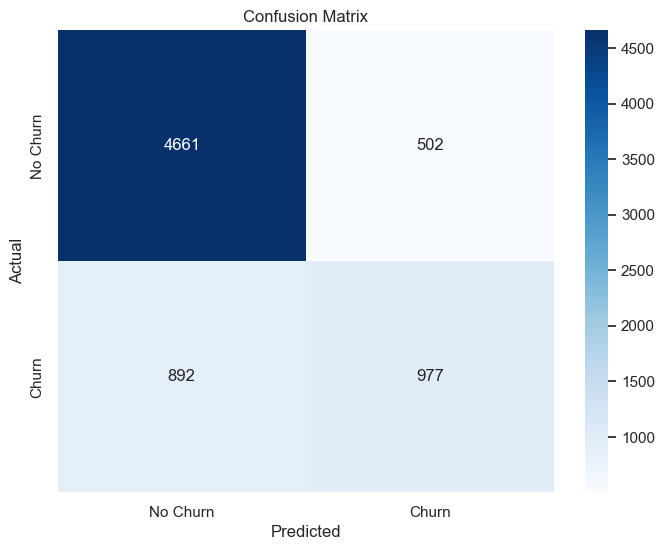

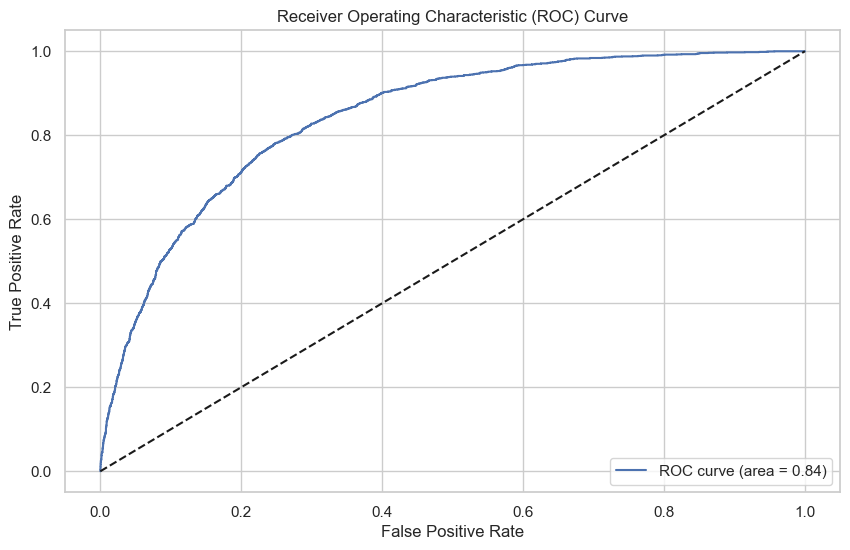

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Assuming y and y_pred are already defined

# Confusion Matrix
y_pred = logit_model.predict(X_low_vif) > 0.5
conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y, logit_model.predict(X_low_vif))
roc_auc = roc_auc_score(y, logit_model.predict(X_low_vif))
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

### Logistic Regression Model Interpretation

This table provides the results of a logistic regression model where the dependent variable is **Churn_Yes** (indicating whether a customer churned).

### **Model Summary:**
- **Pseudo R-squared**: 0.2752 — This indicates that about 27.52% of the variation in the dependent variable (Churn) is explained by the independent variables in the model. This is a relatively moderate Pseudo R-squared, suggesting that other factors might influence churn that are not included in this model or that this model is not a perfect fit for the data.

- Other metrics like **Log-Likelihood**, **LL-Null**, and **LLR p-value** are also provided, which are useful for evaluating the overall significance of the model.

---

### **Coefficients:**

- **Intercept (const)**: -0.9994 — When all other variables are 0, the log-odds of churn is -0.9994. The p-value (0.000) indicates that this is statistically significant.

#### Statistically Significant Variables (p-value < 0.05):
1. **SeniorCitizen** (coef: 0.2632) — Being a senior citizen increases the log-odds of churn by 0.2632, and this effect is statistically significant (p = 0.002).
   
2. **tenure** (coef: -0.0525) — For each additional unit of tenure, the log-odds of churn decreases by 0.0525. This variable is highly significant (p = 0.000).
   
3. **TotalCharges** (coef: 0.0002) — Higher total charges are associated with higher log-odds of churn, though the effect size is very small. This is statistically significant (p = 0.001).
   
4. **Dependents_Yes** (coef: -0.1752) — Having dependents decreases the log-odds of churn by 0.1752, and this is statistically significant (p = 0.049).
   
5. **InternetService_Fiber optic** (coef: 0.4651) — Using fiber optic internet service increases the log-odds of churn by 0.4651, and this is statistically significant (p = 0.009).
   
6. **OnlineSecurity_Yes** (coef: -0.3621) — Having online security decreases the log-odds of churn by 0.3621, and this is highly significant (p = 0.000).
   
7. **TechSupport_Yes** (coef: -0.3516) — Having tech support decreases the log-odds of churn by 0.3516, and this is highly significant (p = 0.000).
   
8. **StreamingMovies_Yes** (coef: 0.1954) — Having streaming movies increases the log-odds of churn by 0.1954, and this is statistically significant (p = 0.038).
   
9. **Contract_One year** (coef: -0.7573) — Having a one-year contract decreases the log-odds of churn by 0.7573, and this is highly significant (p = 0.000).
   
10. **Contract_Two year** (coef: -1.4950) — Having a two-year contract decreases the log-odds of churn by 1.4950, and this is highly significant (p = 0.000).
   
11. **PaperlessBilling_Yes** (coef: 0.3987) — Having paperless billing increases the log-odds of churn by 0.3987, and this is highly significant (p = 0.000).
   
12. **PaymentMethod_Electronic check** (coef: 0.3599) — Using electronic checks increases the log-odds of churn by 0.3599, and this is highly significant (p = 0.000).

The remaining variables are not statistically significant at the 0.05 level.

---

### **Model Fit and Assumptions:**

- **Linearity of Logits**: The model assumes that the log-odds of the dependent variable is a linear combination of the independent variables. This assumption can be checked using the Box-Tidwell test.
  
- **No Multicollinearity**: The model assumes that the independent variables are not highly correlated. This can be checked using the Variance Inflation Factor (VIF).

- **Model Fit**: The model fit can be evaluated using metrics like the confusion matrix, ROC curve, and AUC.

### 2. **ROC Curve and AUC Interpretation**:
  - In this case, the AUC is 0.84, which indicates that the model has good discriminatory ability. This means that the model is able to distinguish between customers who churn and those who do not with a high degree of accuracy.

### Confusion Matrix Interpretation:
    - **TN (True Negative)**: 4661 — Number of correctly predicted non-churn cases.
    - **FP (False Positive)**: 502 — Number of incorrectly predicted churn cases (non-churn predicted as churn).
    - **FN (False Negative)**: 892 — Number of incorrectly predicted non-churn cases (churn predicted as non-churn).
    - **TP (True Positive)**: 977 — Number of correctly predicted churn cases.
  - **Accuracy**: The overall accuracy of the model is calculated as (TN + TP) / (TN + FP + FN + TP) = (4661 + 977) / (4661 + 502 + 892 + 977) ≈ 0.801, or 80.1%.
  - **Sensitivity (Recall)**: The sensitivity or recall of the model is calculated as TP / (TP + FN) = 977 / (977 + 892) ≈ 0.523, or 52.3%. This indicates the proportion of actual churn cases that were correctly identified by the model.
  - **Specificity**: The specificity of the model is calculated as TN / (TN + FP) = 4661 / (4661 + 502) ≈ 0.903, or 90.3%. This indicates the proportion of actual non-churn cases that were correctly identified by the model.
  - **Precision**: The precision of the model is calculated as TP / (TP + FP) = 977 / (977 + 502) ≈ 0.661, or 66.1%. This indicates the proportion of predicted churn cases that were actually correct.

These interpretations provide insights into the logistic regression model's performance and the significance of the predictors in explaining customer churn. The AUC of 0.84 indicates that the model is effective in distinguishing between churn and non-churn customers, while the confusion matrix provides a detailed breakdown of the model's prediction accuracy, sensitivity, specificity, and precision.

### Generalized Additive Model (GAM)

Next, we will build a Generalized Additive Model (GAM) to predict customer churn. GAMs are a flexible class of models that can capture non-linear relationships between the predictors and the response variable. We will use the same set of features as the logistic regression model for the GAM.

In [11]:
gam = LogisticGAM(
    s(1)  # SeniorCitizen
    + s(2)  # tenure
    + s(3)  # MonthlyCharges
    + s(4)  # TotalCharges
    + f(5)  # gender_Male
    + f(6)  # Partner_Yes
    + f(7)  # Dependents_Yes
    + f(8)  # MultipleLines_Yes
    + f(9)  # InternetService_Fiber optic
    + f(10)  # OnlineSecurity_Yes
    + f(11)  # OnlineBackup_Yes
    + f(12)  # DeviceProtection_Yes
    + f(13)  # TechSupport_Yes
    + f(14)  # StreamingTV_Yes
    + f(15)  # StreamingMovies_Yes
    + f(16)  # Contract_One year
    + f(17)  # Contract_Two year
    + f(18)  # PaperlessBilling_Yes
    + f(19)  # PaymentMethod_Credit card (automatic)
    + f(20)  # PaymentMethod_Electronic check
    + f(21)  # PaymentMethod_Mailed check
).fit(X, y)


# Print the summary of the model
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     49.9142
Link Function:                        LogitLink Log Likelihood:                                 -2901.0183
Number of Samples:                         7032 AIC:                                             5901.8651
                                                AICc:                                            5902.6224
                                                UBRE:                                                2.845
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2875
Feature Function                  Lam

C:\Users\osama\AppData\Local\Temp\ipykernel_1712\6878075.py:27: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


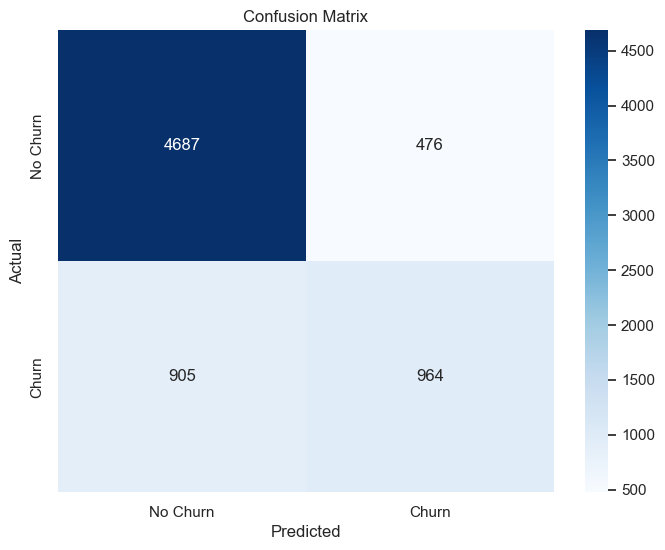

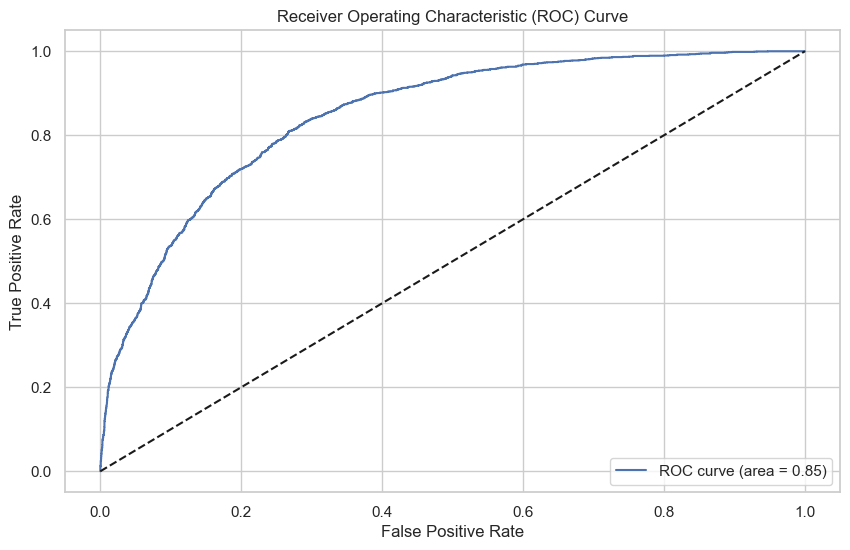

In [12]:
# Predict probabilities
y_pred_prob = gam.predict_proba(X)

# Predict class labels
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = roc_auc_score(y, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In Generalized Additive Models (GAMs), the relationship between the predictors and the response variable is modeled as a sum of smooth functions of the predictors. This is different from linear and logistic regression, where the relationship is modeled as a linear combination of the predictors. 

### Note on Interpreting GAM Coefficients:

In linear and logistic regression, the coefficients represent the change in the response variable for a one-unit change in the predictor, holding all other predictors constant. This direct interpretation is possible because the relationship between the predictors and the response is the same for all features.

However, in GAMs, the coefficients are associated with smooth functions rather than individual predictors. Each smooth function captures the potentially nonlinear relationship between a predictor and the response. As a result, the coefficients in GAMs do not have a straightforward interpretation like in linear or logistic regression. Instead, the interpretation of GAMs focuses on the shape of the smooth functions, which show how the response variable changes with the predictor.


### Confusion Matrix Interpretation:
- **TN (True Negative)**: 4687 — Number of correctly predicted non-churn cases.
- **FP (False Positive)**: 476 — Number of incorrectly predicted churn cases (non-churn predicted as churn).
- **FN (False Negative)**: 905 — Number of incorrectly predicted non-churn cases (churn predicted as non-churn).
- **TP (True Positive)**: 964 — Number of correctly predicted churn cases.
- **Accuracy**: The overall accuracy of the model is calculated as (TN + TP) / (TN + FP + FN + TP) = (4687 + 964) / (4687 + 476 + 905 + 964) ≈ 0.803, or 80.3%.
- **Sensitivity (Recall)**: The sensitivity or recall of the model is calculated as TP / (TP + FN) = 964 / (964 + 905) ≈ 0.516, or 51.6%. This indicates the proportion of actual churn cases that were correctly identified by the model.
- **Specificity**: The specificity of the model is calculated as TN / (TN + FP) = 4687 / (4687 + 476) ≈ 0.908, or 90.8%. This indicates the proportion of actual non-churn cases that were correctly identified by the model.
- **Precision**: The precision of the model is calculated as TP / (TP + FP) = 964 / (964 + 476) ≈ 0.669, or 66.9%. This indicates the proportion of predicted churn cases that were actually correct.
- **ROC Curve and AUC**: The AUC is 0.85, which indicates that the model has very good discriminatory ability. This means that the model is able to distinguish between customers who churn and those who do not with a high degree of accuracy.


### Model Comparison and Judgement

Based on the evaluation metrics and visualizations provided in the notebook, we can draw the following conclusions about the comparative performance of the models:

#### Linear Regression Model

**Confusion Matrix**:
| Actual/Predicted | Predicted No | Predicted Yes |
|----------------|--------------|---------------|
| **Actual No**  | 4675         | 488           |
| **Actual Yes** | 902          | 967           |


#### Logistic Regression Model

**Confusion Matrix**:
| Actual/Predicted | Predicted No | Predicted Yes |
|----------------|--------------|---------------|
| **Actual No**  | 4661         | 502           |
| **Actual Yes** | 892          | 977           |

#### Generalized Additive Model (GAM)

**Confusion Matrix**:
| Actual/Predicted | Predicted No | Predicted Yes |
|----------------|--------------|---------------|
| **Actual No**  | 4687         | 476           |
| **Actual Yes** | 905          | 964           |


### Metrics Summary

| Model                  | Accuracy | Sensitivity (Recall) | Specificity | Precision | AUC  |
|------------------------|----------|----------------------|-------------|-----------|------|
| Linear Regression      | 80.2%    | 51.7%                | 90.5%       | 66.5%     | 0.84 |
| Logistic Regression    | 80.1%    | 52.3%                | 90.3%       | 66.1%     | 0.84 |
| Generalized Additive Model (GAM) | 80.3% | 51.6%       | 90.8%       | 66.9%     | 0.85 |

### Conclusion

- **Generalized Additive Model (GAM)** achieves the highest accuracy (80.3%) and AUC (0.85), indicating very good discriminatory ability. It also has the highest specificity (90.8%) and precision (66.9%) among the three models, but its sensitivity (51.6%) is slightly lower.
- **Linear Regression** model has a slightly lower accuracy (80.2%) and AUC (0.84) compared to the GAM model. Its sensitivity (51.7%) and specificity (90.5%) are also slightly lower, but it still demonstrates good performance.
- **Logistic Regression** model has an accuracy of 80.1% and an AUC of 0.84, which are comparable to the Linear Regression model. Its sensitivity (52.3%) is the highest among the three models, but its specificity (90.3%) and precision (66.1%) are slightly lower.

Overall, the Generalized Additive Model (GAM) performs slightly better than the Linear and Logistic Regression models in terms of accuracy, AUC, specificity, and precision. However, all models achieve very similar performance in predicting customer churn. Accordingly, we advise the telecommunications company to consider the Generalized Additive Model (GAM) for predicting customer churn due to its superior performance metrics.